# Graph Neural Network

In this project, we imagine that there is a school with international sutdents, and we want to check if the international students are more likely to form networks with students from their home countries than any other group.

In order to mimic this, we will first build a "student" data set using the Karate Club graph dataset from
`torch.geometric.datasets` and allocate the students to different countries.



## Install packages
First we install the necessary packages

In [ ]:
!pip install torch-geometric optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.0 MB/s eta 0:00:00


## Import packages
Now, we import the packages required

In [ ]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch.nn import Linear
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import optuna
import pandas as pd


## Load Dataset
Now we load the karate cub dataset to prepare it and turn it into the student dataset

In [ ]:
# Load Karate club dataset
dataset = KarateClub()
data = dataset[0]
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [ ]:
data.num_features

34

## Convert graphs to data frames and create data sets with students from different countries

### convert node features to df

In [ ]:
# convert node features to pandas dataframe
node_features_df = pd.DataFrame(data.x.numpy(),
                                columns=[f'features{i}' for i in range(data.x.shape[1])])
node_features_df.head()

,features0,features1,features2,features3,features4,features5,features6,features7,features8,features9,...,features24,features25,features26,features27,features28,features29,features30,features31,features32,features33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)
node_features_df.head()

,features0,features1,features2,features3,features4,features5,features6,features7,features8,features9,...,features24,features25,features26,features27,features28,features29,features30,features31,features32,features33
node,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert edge indices to df

In [ ]:
# convert edge indices to a pandas df
edge_idx_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])
edge_idx_df.head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


### Convert labels to df

In [ ]:
# convert labels to pandas df
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)
labels_df.head()

,label
node,
0,1
1,1
2,1
3,1
4,3


### print new dfs

In [ ]:
# print the number of nodes
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")

Number of nodes: 34


In [ ]:
# Print the number of edges
num_edges = data.edge_index.shape[1]
print(f"Number of edges: {num_edges}")

Number of edges: 156


In [ ]:
# Print node features DataFrame
print(f"\nNode features (shape: {node_features_df.shape}):")
print(node_features_df.head())


Node features (shape: (34, 34)):
      features0  features1  features2  features3  features4  features5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   

      features6  features7  features8  features9  ...  features24  features25  \
node                                              ...                           
0           0.0        0.0        0.0        0.0  ...         0.0         0.0   
1           0.0        0.0        0.0        0.0  ...         0.0         0.0   
2           0.0        0.0        0.0        0.0  ...         0.0         0.0   
3           0.0        0.0        0.0     

In [ ]:
# Print edge indices DataFrame
print(f"\nEdge indices (shape: {edge_idx_df.shape}):")
print(edge_idx_df.head())


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [ ]:
# Print labels DataFrame
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


## Preprocess countries

In [ ]:
# number of countries
num_countries = 4

# assign students to countries(using labels)
# we use a seed so the experiment is recreatable
np.random.seed(42)
countries = torch.tensor(np.random.choice(num_countries, num_nodes))

# update the labels in the data object
data.y = countries

In [ ]:
# verify the data
print(data)
print(f'x = {data.x.shape}')
print(data.x)
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)
print(f'y = {data.y.shape}')
print(data.y)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

### Check if graph is as expected

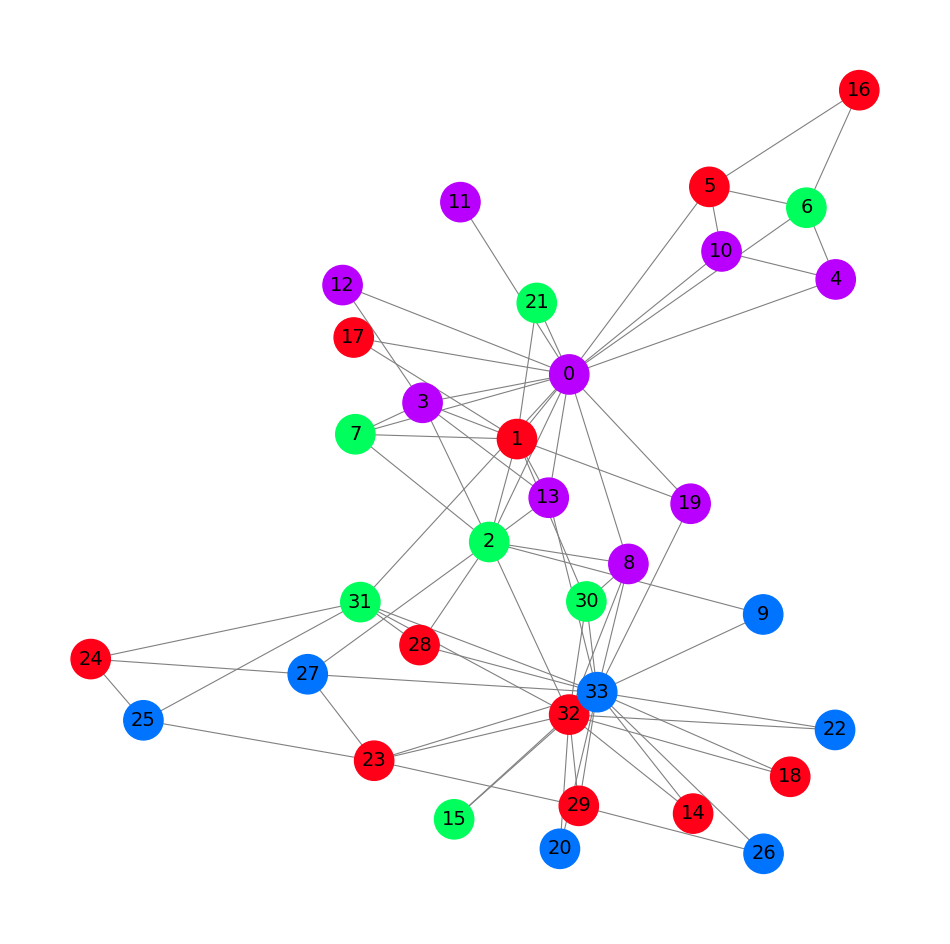

In [ ]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12, 12))
plt.axis('off')
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0),
                 with_labels=True, node_color=data.y,
                 node_size=800, cmap='hsv',
                 vmin=-2,vmax=3, width=0.8,
                 edge_color='grey',
                 font_size=14)

plt.show()

## Build Model
Next, we build the NN model

### Define model architecture
The model works by initially randomly assuming that all nodes belong to the same class, and then using the GNN model, it gets information on neighboring nodes and updates the neighboring nodes classification which leads to eventually learning the pattern in the graph.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, num_countries)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z


model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


### Set the hyper parameters

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)#).item()

In [ ]:
# data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

### Training Loop

In [ ]:
for epoch in range(200):
    # forward pass
    h, z = model(data.x, data.edge_index)

    # calculate the loss
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)

    # optimize the zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:>3}| Loss: {loss:.2f} | Acc: {acc * 100:.2f}%')

Epoch:   0| Loss: 1.42 | Acc: 8.82%
Epoch:  10| Loss: 1.33 | Acc: 32.35%
Epoch:  20| Loss: 1.26 | Acc: 32.35%
Epoch:  30| Loss: 1.16 | Acc: 55.88%
Epoch:  40| Loss: 1.02 | Acc: 64.71%
Epoch:  50| Loss: 0.88 | Acc: 64.71%
Epoch:  60| Loss: 0.76 | Acc: 70.59%
Epoch:  70| Loss: 0.66 | Acc: 79.41%
Epoch:  80| Loss: 0.57 | Acc: 82.35%
Epoch:  90| Loss: 0.50 | Acc: 88.24%
Epoch: 100| Loss: 0.44 | Acc: 91.18%
Epoch: 110| Loss: 0.38 | Acc: 91.18%
Epoch: 120| Loss: 0.33 | Acc: 94.12%
Epoch: 130| Loss: 0.28 | Acc: 97.06%
Epoch: 140| Loss: 0.23 | Acc: 100.00%
Epoch: 150| Loss: 0.19 | Acc: 100.00%
Epoch: 160| Loss: 0.16 | Acc: 100.00%
Epoch: 170| Loss: 0.14 | Acc: 100.00%
Epoch: 180| Loss: 0.12 | Acc: 100.00%
Epoch: 190| Loss: 0.10 | Acc: 100.00%


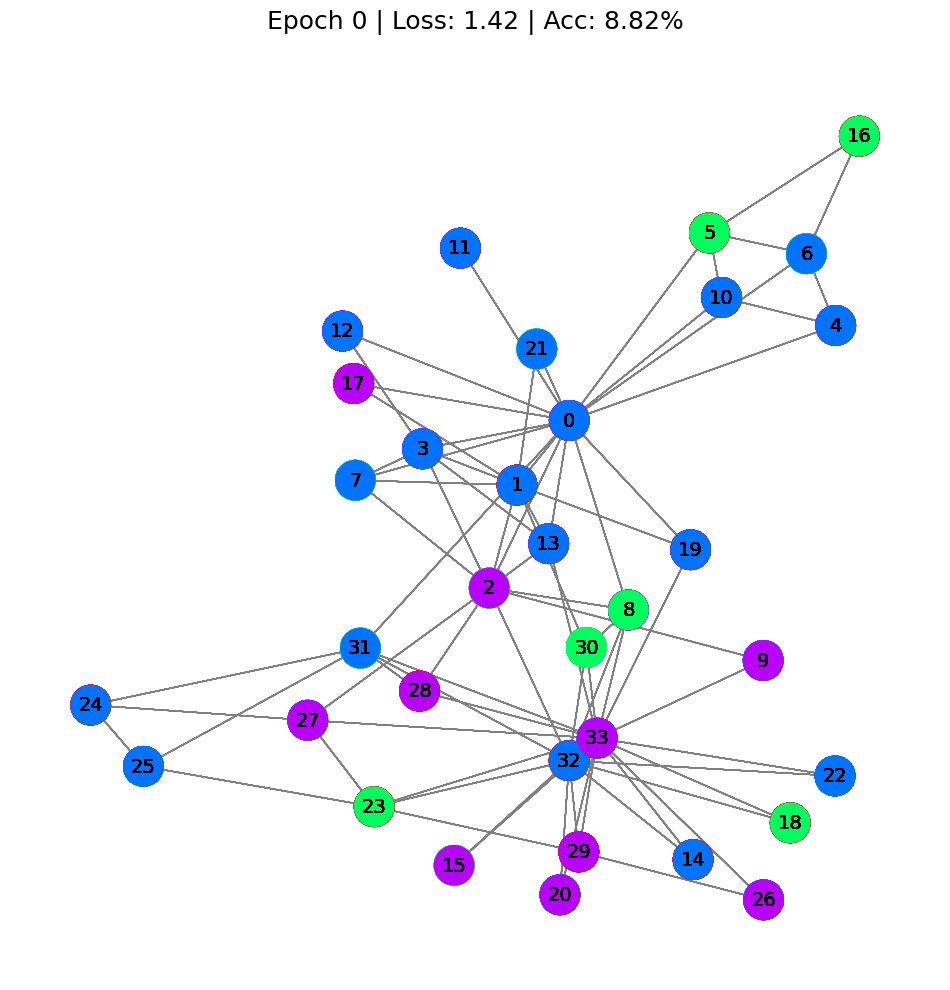

In [ ]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.bitrate'] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i].numpy(),
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14)
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=20)


fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

### 3D Embeddings Visualization

In [ ]:
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[3.0201e+00, 0.0000e+00, 2.2586e+00],
        [1.4130e+00, 0.0000e+00, 1.8484e+00],
        [1.7621e+00, 0.0000e+00, 0.0000e+00],
        [2.5618e+00, 0.0000e+00, 1.2053e+00],
        [2.6285e+00, 0.0000e+00, 1.1339e+00],
        [1.3278e+00, 0.0000e+00, 1.8802e+00],
        [1.2483e+00, 0.0000e+00, 1.2964e-01],
        [1.5272e+00, 0.0000e+00, 1.3135e-01],
        [1.8256e+00, 0.0000e+00, 8.6531e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.6060e+00, 0.0000e+00, 1.1156e+00],
        [2.8688e+00, 0.0000e+00, 1.3741e+00],
        [2.9126e+00, 0.0000e+00, 1.4866e+00],
        [1.9862e+00, 0.0000e+00, 9.2169e-01],
        [4.6795e-01, 0.0000e+00, 1.5319e+00],
        [1.4052e+00, 0.0000e+00, 1.3787e-04],
        [1.7022e-01, 0.0000e+00, 9.0791e-01],
        [6.5343e-01, 0.0000e+00, 1.2409e+00],
        [5.2862e-01, 0.0000e+00, 1.6178e+00],
        [2.0695e+00, 0.0000e+00, 9.4250e-01],
        [7.3177e-04, 0.0000e+00, 0.0000e+

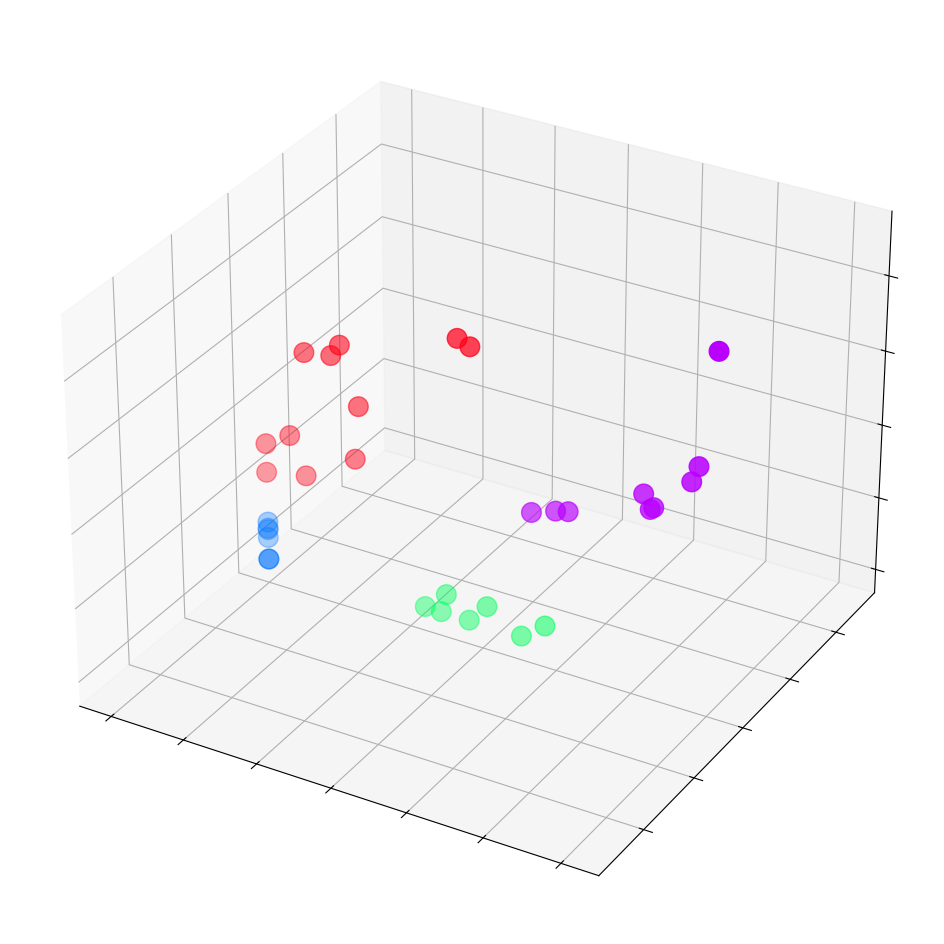

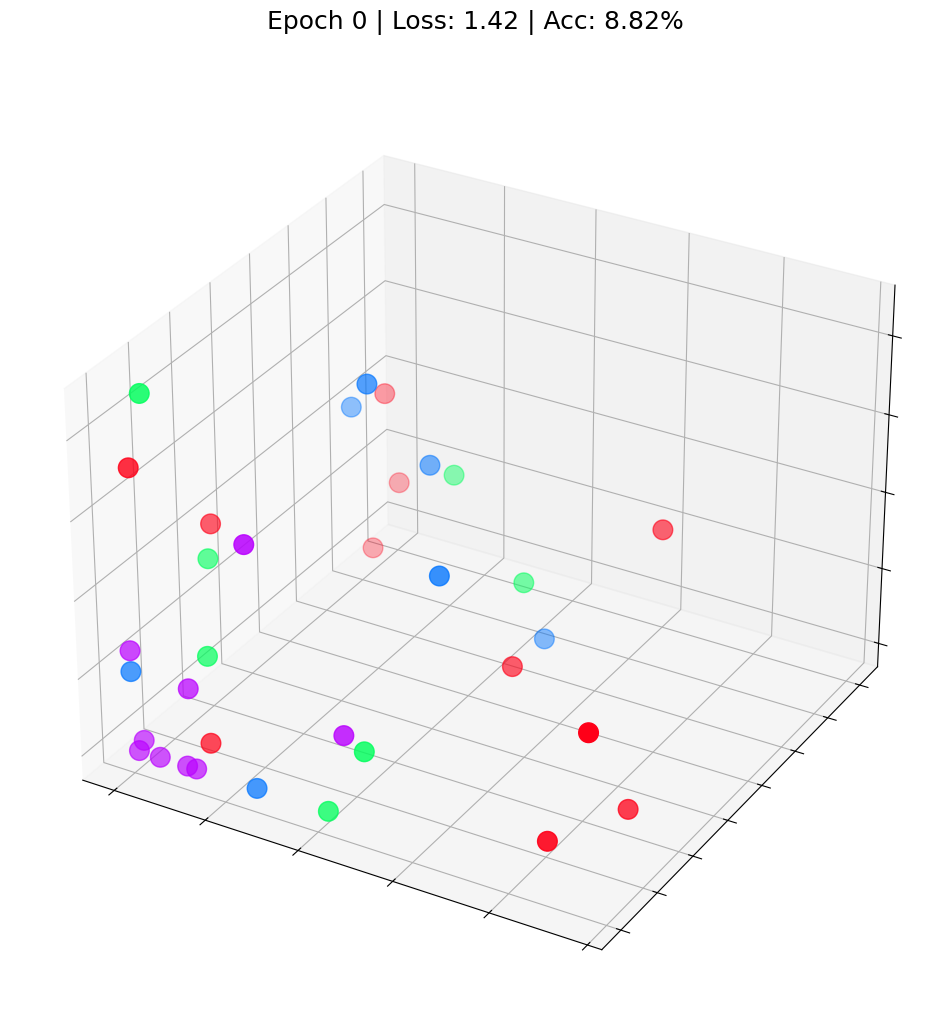

In [ ]:
embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap='hsv', vmin=-2, vmax=3)

plt.show()

def animate_3d(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
               s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=40)


fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
anim = animation.FuncAnimation(fig, animate_3d, np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)


## References


*   [Tutorial](https://www.youtube.com/watch?v=sozkSRE8wyc&t=478s&ab_channel=Vizuara)


